<p style="font-size:30px"><b> 5th Model - Weighted majority model </b></p>
 
<p style="font-size:20px">The main assumptions of this model are following:</p>
<ol>
    <li>
        There are four graphs, which represents interactions in society: 
        <ul>
            <li><b>G</b> - rectangular neighbourhood network</li>
            <li><b>K</b> - social interactions network</li>
            <li><b>K_temp</b> - temporary social interactions network (generates for each iteration)</li>
            <li><b>L</b> - social media network (social media are for or against EV - it changes in each iteration)</li>
        </ul>
    </li>
    <li>
        There are two different possibilities in opinions:
        <ul>
            <li><b>1</b> - agent is against EV</li>
            <li><b>-1</b> - agent is for EV</li>
        </ul>
    </li>
    <li>
        <font color="red">At the beginning there are agents with different opinions (based on real number of EV)</font>
    </li>
    <li>
        There are two possibilities of changing opinion by agents:
        <ul>
            <li><b>independent flip</b> - with a given probability $p$ agent changes its opinions independently</li>
            <li><b>conformity flip</b> - <font color="red">if value of neighbours opinion is higher than zero, it becomes against electric vehicles, otherwise it is for electric vehicles. Value of neighbours opinion is a sum of opinions of q randmoly chosen neighbours from every considered network multiplied by coefficient of weight for every network </font></li>
        </ul>
</ol>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import trange
import pickle

In [2]:
def spinson_independent_flip(opinions, spinson):
    opinions[spinson] = -1 if opinions[spinson] == 1 else 1
    
    return opinions

In [3]:
def spinson_conformity_flip_v2(graphs, opinions, spinson, q, coefficients):
    neighbours = []
    neighbours_opinion = 0
    for i in range(len(graphs)): 
        if len(list(graphs[i].neighbors(spinson))) < q:
            neighbours = list(graphs[i].neighbors(spinson))
        else:
            neighbours = random.sample(list(graphs[i].neighbors(spinson)), q)
        if len(neighbours) != 0:
            neighbours_opinions = [opinions[neighbour] for neighbour in neighbours]
            neighbours_opinion += coefficients[i]*sum(neighbours_opinions)/len(neighbours)
    if neighbours_opinion > 0:
        opinions[spinson] = 1
    elif neighbours_opinion < 0:
        opinions[spinson] = -1

    return opinions

In [4]:
def q_voter_simulation_v2(graphs, p, q, iterations, coefficients, h):
    magnetization = []

    opinions = [1]*len(G)
    while opinions.count(-1) < 2:  # agents have different opinions at the beginning of simulation
        opinions[random.randint(0, len(G)-1)] = -1
    
    social_media_opinion = [1] 
    opinions = opinions + social_media_opinion
    
    magnetization.append(sum(opinions[:-1])/len(graphs[0]))
    for i in range(iterations):
        # in every iteration graph of temporary interactions and opinion of social media is changing
        graphs[-2] = nx.fast_gnp_random_graph(len(graphs[0].nodes()), random.uniform(0.0001, 0.001))
        if random.random() < h: # social media influence change opinion
            opinions[-1] = -1
        else:
            opinions[-1] = 1
        # choosing neighbours
        for i in range(len(graphs[0])):
            spinson = random.choice(list(graphs[0].nodes()))  #  chooses one random node
            if random.random() < p:  #  does it act independtly?
                if random.random() < 0.5:  # the same probability to change opinion
                    opinions = spinson_independent_flip(opinions, spinson)
            else:
                opinions = spinson_conformity_flip_v2(graphs, opinions, spinson, q, coefficients)

        magnetization.append(sum(opinions[:-1])/len(graphs[0]))

    return magnetization

In [5]:
def calculate_magnetization(graphs, p, q, mc, iterations, coefficients, h):
    magnetizations = []
    final_magnetizations = []
    if type(p) == list and type(q) != list:
        for j in range(len(p)):  
            magnetization = np.zeros(iterations+1)
            for i in range(mc):    
                magnetization = magnetization + q_voter_simulation_v2(graphs, p[j], q, iterations, coefficients, h)
            magnetizations.append(magnetization/mc)
            final_magnetizations.append(magnetization[-1]/mc)
            
    elif type(p) != list and type(q) == list:
        for j in range(len(q)):  
            magnetization = np.zeros(iterations+1)
            for i in range(mc):    
                magnetization = magnetization + q_voter_simulation_v2(graphs, p, q[j], iterations, coefficients, h)
            magnetizations.append(magnetization/mc)
            final_magnetizations.append(magnetization[-1]/mc)
        
    return magnetizations, final_magnetizations

In [6]:
def magnetization_independent_runs(graphs, p, q, N, iterations, coefficients, h):
    magnetizations = []
    for i in trange(N):
        magnetizations.append(q_voter_simulation_v2(graphs, p, q, iterations, coefficients, h))

    return magnetizations

## Loading saved

In [7]:
G = nx.read_gpickle('small_network_neighbourhood.pickle')
K = nx.read_gpickle('small_social_neighbourhood.pickle')
L = nx.read_gpickle('small_social_media.pickle')

# Simulations

### Independent runs for $p = 0.2$ and $q=3$

In [8]:
graphs = [G, K, None, L]
p = 0.2
q = 3
mc = 10
h = 0.5
iterations = 100
coefficients = [0.25, 0.25, 0.25, 0.25]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.50it/s]


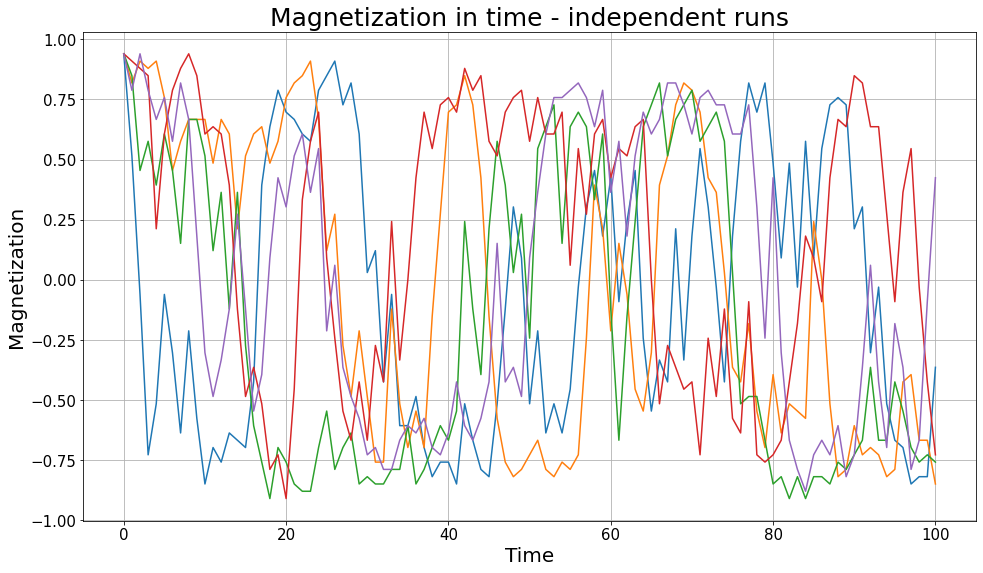

In [9]:
plt.figure(figsize=(16, 9))
for _ in trange(5):
    x = q_voter_simulation_v2(graphs, p, q, iterations, coefficients, h)
    plt.plot(x)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title('Magnetization in time - independent runs', fontsize=25)
plt.grid()

### Independent runs for $p = 0$ and $q=4$

In [10]:
graphs = [G, K, None, L]
p = 0
q = 4
h = 0.5
iterations = 1000
coefficients = [0.25, 0.25, 0.25, 0.25]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:02<00:00,  2.42s/it]


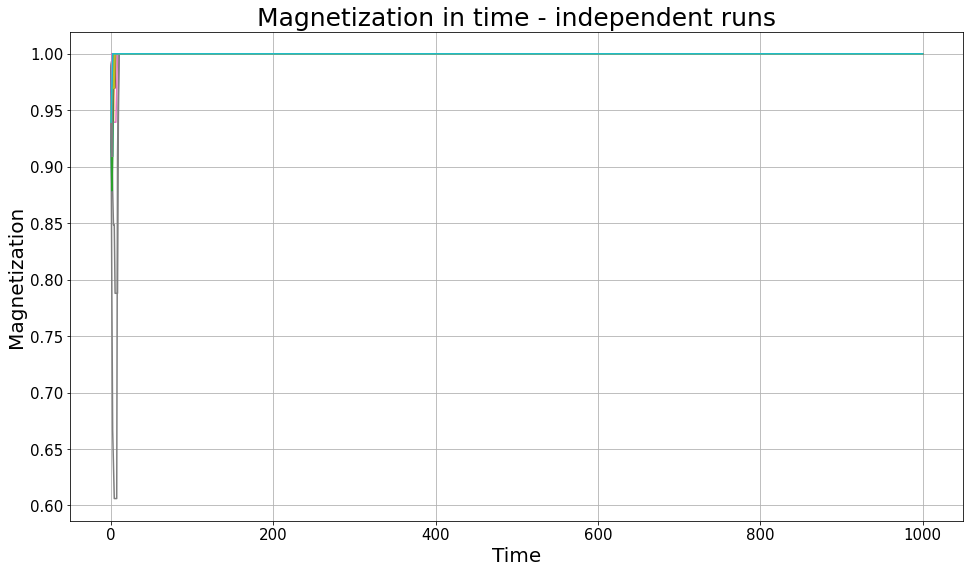

In [11]:
plt.figure(figsize=(16, 9))
for _ in trange(100):
    x = q_voter_simulation_v2(graphs, p, q, iterations, coefficients, h)
    plt.plot(x)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title('Magnetization in time - independent runs', fontsize=25)
plt.grid()

## Magnetization for different values of $𝑝 = (0.05, 0.15, 10)$ and $𝑞=5$

In [12]:
graphs = [G, K, None, L]
ps = np.linspace(0.05, 0.15, 10)
q = 5
h = 0.5
mc = 10
iterations = 120
coefficients = [0.25, 0.25, 0.25, 0.25]

In [13]:
magnetizations, final_magnetizations = [], []
for p in trange(len(ps)):
    x, y = calculate_magnetization(graphs, [ps[p]], q, mc, iterations, coefficients, h)
    magnetizations.append(x)
    final_magnetizations.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


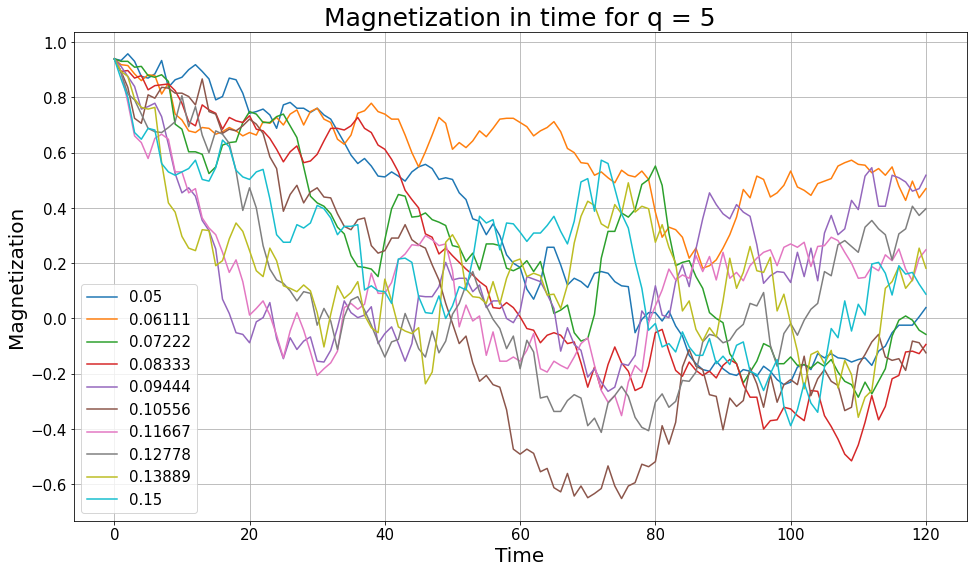

In [14]:
plt.figure(figsize=(16, 9))
for i, magnetization in enumerate(magnetizations):
    plt.plot(range(0, len(magnetization[0])), magnetization[0], label=f'{round(ps[i], 5)}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title(f'Magnetization in time for q = {q}', fontsize=25)
plt.grid()
plt.legend(prop={'size': 15})

## Magnetization for different values of $𝑝 = (0.01, 0.15, 10)$ and $𝑞=4$

In [15]:
graphs = [G, K, None, L]
ps = np.linspace(0.01, 0.15, 10)
q = 4
h = 0.5
mc = 10
iterations = 120
coefficients = [0.25, 0.25, 0.25, 0.25]

In [16]:
magnetizations, final_magnetizations = [], []
for p in trange(len(ps)):
    x, y = calculate_magnetization(graphs, [ps[p]], q, mc, iterations, coefficients, h)
    magnetizations.append(x)
    final_magnetizations.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.33s/it]


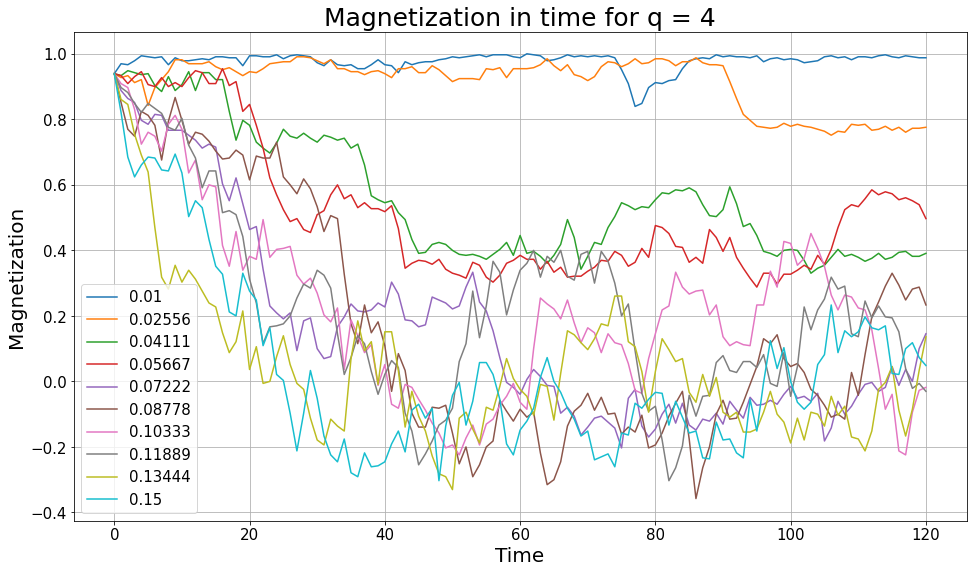

In [17]:
plt.figure(figsize=(16, 9))
for i, magnetization in enumerate(magnetizations):
    plt.plot(range(0, len(magnetization[0])), magnetization[0], label=f'{round(ps[i], 5)}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title(f'Magnetization in time for q = {q}', fontsize=25)
plt.grid()
plt.legend(prop={'size': 15})

## Magnetization for different values of $q = (1, 10, 10)$ and $p=0.1$

In [18]:
graphs = [G, K, None, L]
p = 0.1
qs = np.linspace(1, 10, 10)
h = 0.5
mc = 10
iterations = 120
coefficients = [0.25, 0.25, 0.25, 0.25]

In [19]:
magnetizations, final_magnetizations = [], []
for q in trange(len(qs)):
    x, y = calculate_magnetization(graphs, p, [int(qs[q])], mc, iterations, coefficients, h)
    magnetizations.append(x)
    final_magnetizations.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


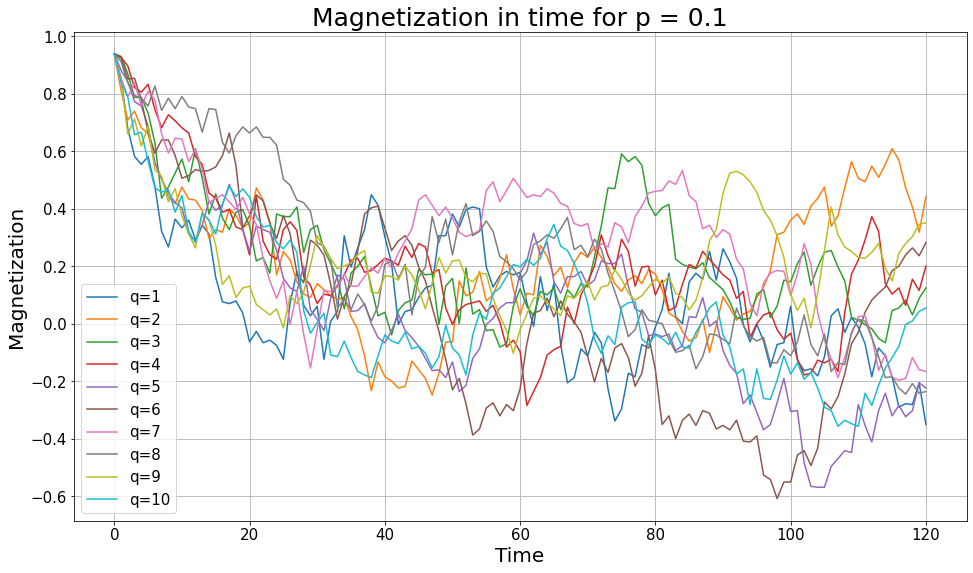

In [20]:
plt.figure(figsize=(16, 9))
for i, magnetization in enumerate(magnetizations):
    plt.plot(range(0, len(magnetization[0])), magnetization[0], label=f'q={round(qs[i])}')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title(f'Magnetization in time for p = {p}', fontsize=25)
plt.grid()
plt.legend(prop={'size': 15})

## Independent run

In [21]:
graphs = [G, K, None, L]
p = 0.1
q = 3
h = 0.5
iterations = 120
coefficients = [0.25, 0.25, 0.25, 0.25]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.82it/s]


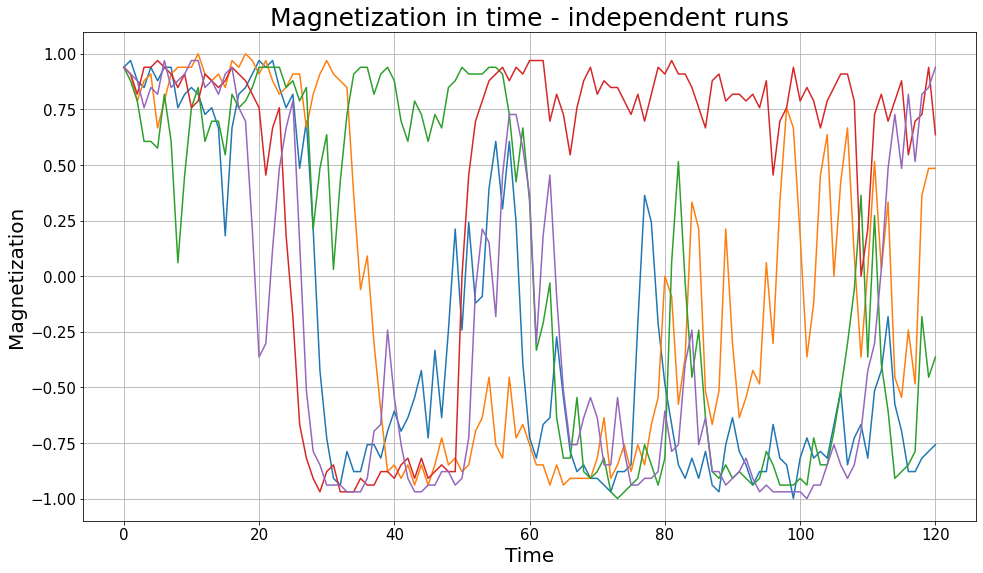

In [22]:
plt.figure(figsize=(16, 9))
for _ in trange(5):
    x = q_voter_simulation_v2(graphs, p, q, iterations, coefficients, h)
    plt.plot(x)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title('Magnetization in time - independent runs', fontsize=25)
plt.grid()